We need to :

1. generate data
2. define priors in lim space
3. do inference in limited space
4. in inference expand space for update
5. shrink back for global update 
6. repeat till convergence

Stuff thats different :

Dirichlet(a_11 , ... , a_1n )= Dirichlet (a_12, ... ,a_1N) i.e. the diagonal entry of the transition matrix is set to 0 


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from pybasicbayes.distributions import Gaussian
from sklearn.cluster import KMeans

/Users/lenkasefcakova/Desktop/variational-inf-for-HSMM/pybasicbayes/distributions/multinomial.py:21: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')
/Users/lenkasefcakova/Desktop/variational-inf-for-HSMM/pybasicbayes/distributions/negativebinomial.py:25: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')


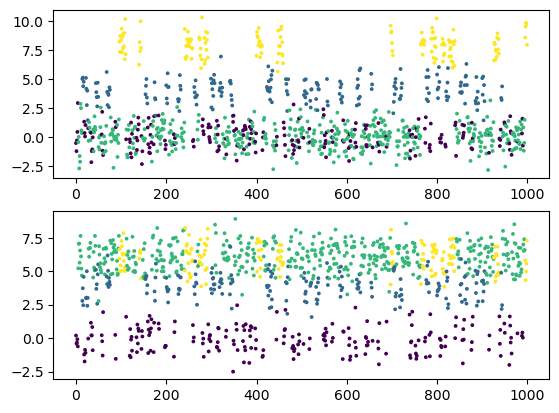

In [10]:
centers = np.array([np.array([0,0]),np.array([4,4]),np.array([0,6]),np.array([8,6])])


K = 4           # number of states  
D = 2        #have to be equal (symmetry)
kappa_0 = 1.5     #??? variance of emissions ?
nu_0 = 4        #??? smoothing?

T = np.array([
    [0 ,0.3,0.6,0.1],
    [0.2, 0 ,0.7,0.1],
    [0.7,0.2, 0 ,0.1],
    [0.7,0.2,0.1, 0 ]
    ])

N = 1000
lambda_js = np.arange(1,K+1)*2 + 2


from generate_data import *
emit = make_emissions(centers , kappa_0, nu_0)

seq_hsmm, ind = generate_states_pois(T,lambda_js,N)

obs_hsmm = generate_data(emit,ind)
fig, axs = plt.subplots(2, 1)

axs[0].scatter([i for i in range(N)],obs_hsmm[:,0],s=3, c =seq_hsmm )
axs[1].scatter([i for i in range(N)],obs_hsmm[:,1],s=3, c =seq_hsmm )

In [16]:
kmeans = KMeans(init="random",n_clusters=K,n_init=10,max_iter=300,random_state=1)
kmeans.fit(obs_hsmm)

mu_0 = kmeans.cluster_centers_ #np.zeros(D)
sigma_0 = 0.75*np.cov(obs_hsmm.T)
kappa_0 = 10 # high value for stability (low rescale when Gaussian mu_0 --> mu_mf resample(--> nat_to_standard()))
# if we use the KMeans we are pretty confident in the centers so we can set a high value
# consult this step with Jack and Benni !!!!!!!!!!!!!
nu_0 = 4

# define emissions for each super state
prior_emit = [Gaussian(mu_0=mu_0[i], sigma_0=sigma_0, kappa_0=kappa_0, 
                        nu_0=nu_0) for i in range(K)]
prior_emit = np.array(prior_emit)           # prior on emissions retype
prior_A = np.ones(K*K).reshape((K,K))    # prior on transition matrix all 1
np.fill_diagonal(prior_A, 0)

prior_pi0 = np.ones(K)                     # ?
# -----------------------------------------------------------------
# page break
m_js,lambda_js = np.ones(K,dtype='int')*10, np.array(lambda_js,dtype='int')



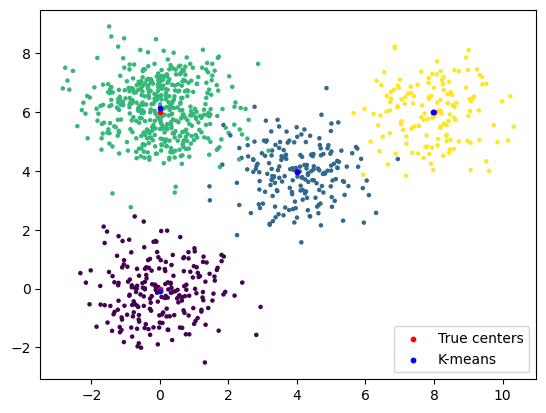

In [17]:
plt.scatter(obs_hsmm[:,0],obs_hsmm[:,1],  s=5, c =seq_hsmm)
plt.scatter(centers[:,0],centers[:,1], s=10, c='red',label = 'True centers')
plt.scatter(mu_0[:,0],mu_0[:,1], s=10, c='blue', label = 'K-means')
plt.legend()
plt.show()

In [18]:
import pandas as pd
np.savetxt("data.csv", obs_hsmm, delimiter=",")


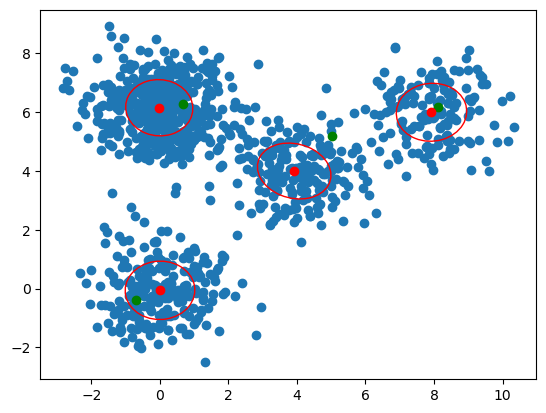

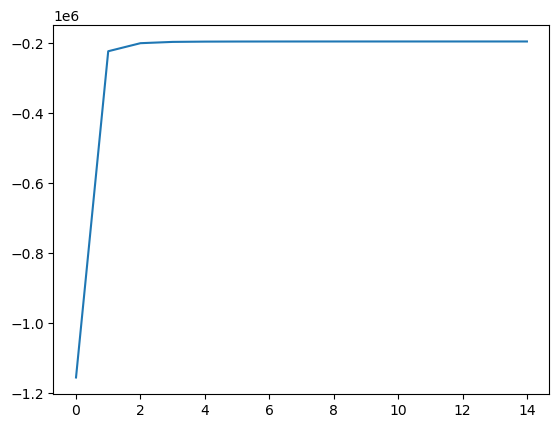

time is:  3.0902481079101562


In [20]:
import hsmmbatchcd as HSMM
import util
from scipy.stats import invwishart,t,beta
import time 
# define object for inferrence from hmmbatchcd.py
# # pass priors on init transitions and emissions for each state
hsmm = HSMM.VBHSMM(obs_hsmm, prior_pi0, prior_A, prior_emit,m_js,lambda_js,maxit=15, epsilon=10**(-10))  
start_time = time.time()
hsmm.infer() # do inference 
end_time = time.time()
sts_true = seq_hsmm # true states 
# hamming distance
##print(prior_emit[0].mu_mf)
##print('Hamming Distance = ', hmm.hamming_dist(hmm.var_x, sts_true)[0]) 

# plot learned emissions over observations

# plots mean_field values (prior in green, posterior approximations in red)
# prior values are green
# var_emit are red 
a = util.plot_emissions(obs_hsmm, prior_emit, hsmm.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hsmm.elbo_vec)
plt.show()
elapsed_time_VB = end_time - start_time 
print('time is: ',elapsed_time_VB)

In [21]:
m_js,lambda_js

(array([10, 10, 10, 10]), array([ 4,  6,  8, 10]))

In [22]:
import stan
import numpy as np
import nest_asyncio
import time
nest_asyncio.apply()
mu_0_ = KMeans(init="random",n_clusters=1,n_init=10,max_iter=300,random_state=42).fit(obs_hsmm).cluster_centers_[0]
dat = [tuple(i) for  i in obs_hsmm]
data = {'y':dat , "N": N, "D":D, "K":K,'m':m_js, 'mu_0':mu_0_ , 'kappa_0':kappa_0/K, 'nu_0':nu_0,'Psi_0':sigma_0,'alpha_0':np.ones((K,K-1)),'lambda':lambda_js} #specify dirichlet prior [1,1,1,...] on transitions

# read code from .stan file 
with open('BenJackCode/MvNormEmis_approxHSMM_PoisDur_lambdaFixed.stan') as f:
    stan_code = f.read()

# build stan model 
jack_model = stan.build(stan_code,data)

N_MCMC = 1000 

# start sampling
start_time = time.time()
fit = jack_model.sample(num_chains = 1, num_samples = 1000+N_MCMC, num_warmup = 700 )
end_time = time.time()

elapsed_time_MCMC = end_time - start_time 

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/httpstan_upt2n2te/model_7nymjnd5.stan', line 41, column 33: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/httpstan_upt2n2te/model_7nymjnd5.stan', line 45, column 6: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/httpstan_upt2n2te/model_7nymjnd5.stan', line 70, column 25: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan

In [ ]:
import pandas as pd
fit.to_dataframe().to_csv('fit.csv', encoding='utf-8')

AttributeError: 'NoneType' object has no attribute 'to_dataframe'

In [15]:
from scipy.stats import invwishart,t,beta
import seaborn as sns

MCMC_mus = {}
MCMC_sig = {}
MCMC_gamm = {}

true_map_MCMC = [np.argmin(np.sqrt(np.sum((np.mean(fit['mu'][i].T, axis =0)-centers)**2,axis =1)))+1 for i in range(fit['mu'].shape[0])]

for i in range(fit['mu'].shape[0]):
    MCMC_mus[str(true_map_MCMC[i])] = fit['mu'][i].T
    MCMC_sig[str(true_map_MCMC[i])] = fit['Sigma'][i].T
    MCMC_gamm[str(true_map_MCMC[i])] = {}
    for j in range(fit['mu'].shape[0]):
        MCMC_gamm[str(true_map_MCMC[i])][str(true_map_MCMC[j])] = fit['gamma'][i].T[:,j]
        
VI_mus = {}
VI_sig = {}
VI_kapp = {}
VI_nu = {}
VI_alphas = {}

true_map_VI = [np.argmin(np.sqrt(np.sum((hsmm.var_emit[i].mu_mf - centers)**2,axis =1)))+1 for i in range(K)]

for i in range(0,len(hsmm.var_emit)):
    VI_mus[str(true_map_VI[i])] = hsmm.var_emit[i].mu_mf
    VI_sig[str(true_map_VI[i])] = hsmm.var_emit[i].sigma_mf
    VI_kapp[str(true_map_VI[i])] = hsmm.var_emit[i].kappa_mf
    VI_nu[str(true_map_VI[i])] = hsmm.var_emit[i].nu_mf
    VI_alphas[str(true_map_VI[i])] = {}
    for j in range(0,len(hsmm.var_emit)):
        VI_alphas[str(true_map_VI[i])][str(true_map_VI[j])] = hsmm.var_A[i][j]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey=True)

for k in range(K):
    for d in range(D):
        ax = axs[k,d]

        ax.vlines(centers[k][d],0,20,color = 'black',label='truth')

        ax.vlines(np.mean(MCMC_mus[str(k+1)].T[d]),0,20,color = 'royalblue',linestyles='dotted',linewidth = 2, label='MCMC mean')
        sns.kdeplot(MCMC_mus[str(k+1)].T[d],label='MCMC density',ax=ax,color = 'royalblue')

        x = np.linspace(centers[k][d]-0.6,centers[k][d]+0.6,500)
        scale_kd = np.diag(VI_sig[str(k+1)])[d] / (VI_kapp[str(k+1)]*( VI_nu[str(k+1)] + D - 1 ))
        
        ax.plot(x, t.pdf(x, df = VI_nu[str(k+1)], loc=VI_mus[str(k+1)][d], scale=np.sqrt(scale_kd)),label = 'VI students-t',color = 'orange')
        ax.vlines(VI_mus[str(k+1)][d],0,20,color = 'orange',label='VI',linestyles='dashed')

        # plt.ylim((0,20))
plt.suptitle('Mu Posterior HSMM')
plt.legend(fontsize = 8)
plt.tight_layout()


In [ ]:
from scipy.stats import invwishart
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey = True)
for k in range(K):
    for d in range(D):

        ax = axs[k,d]

        ax.vlines(1,0,10,color = 'red',label='truth')
        
        ax.vlines(np.mean(MCMC_sig[str(k+1)][:][:,d,d]),0,10,color = 'royalblue',linestyles='dotted',linewidth = 2, label='MCMC mean')

        sns.kdeplot(MCMC_sig[str(k+1)][:][:,d,d],label='MCMC density',ax=ax,color = 'royalblue')

        x = np.linspace(0.1,2,500)
        iw = invwishart.pdf(x, df=VI_kapp[str(k+1)], scale = np.diag(VI_sig[str(k+1)])[d])
        ax.plot(x, iw, label = 'VI',color = 'orange')
        
        ax.sharex(axs[:][d][0])

plt.suptitle('Sigma (variance) posterior HSMM')
# plt.legend(fontsize = 8)
plt.tight_layout()

In [ ]:
K=4
fig, axs = plt.subplots(K, K,figsize=(8, 8))#,sharey=  True,sharex=  True
for k in range(K):
    for j in range(K):
        if k==j:
            pass
        else:
            ax = axs[k,j]
            sns.kdeplot(MCMC_gamm[str(k+1)][str(j+1)],label='MCMC density',ax=ax,linewidth=1.0, color = 'royalblue')
            x = np.linspace(0,max(MCMC_gamm[str(k+1)][str(j+1)]),500)
            # x = np.linspace(0,1,500)
            dist = beta.pdf(x,VI_alphas[str(k+1)][str(j+1)] , sum(VI_alphas[str(k+1)].values())-VI_alphas[str(k+1)][str(j+1)])
            ax.plot(x, dist,label = 'VI',color = 'red',linewidth=1.0,linestyle = 'dashed')
            ax.vlines(T[k][j],0,30,color = 'red',label='truth',linewidth=1.0,linestyle = 'dotted')

            # ax.set_xlim(0,1)
            ax.set(ylabel=None)
        # if k==(K-1):
        #     if j==(K-2):
        #         ax.legend(['VI', 'truth'], fontsize=8)



plt.suptitle('Gammas')
plt.tight_layout()
plt.show()